In [119]:
import numpy as np
import logging
import nibabel as nib
import math
import matplotlib.pyplot as plt
from numpy import linalg as LA
from skimage.segmentation import slic
from pathlib import Path
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from tqdm import tqdm_notebook as tqdm

In [127]:
def various_crop_3d(img, label, least_size):
    """
    Args:
        img: (numpy.ndarray)
    Returns:
        cropped_img: (numpy.ndarray)
    """
    h_size = img.shape[0]
    w_size = img.shape[1]
    d_size = img.shape[2]
    
    anchor = [0, least_size, 0, least_size, 0, least_size]
    
    line_h = img.sum(tuple([1, 2]))
    line_w = img.sum(tuple([0, 2]))
    line_d = img.sum(tuple([0, 1]))

    flag = False
    for i in range(h_size):
        if flag==False and line_h[i]!=0:
            anchor[0] = i
            flag = True
        elif flag==True and line_h[i]==0:
            anchor[1] = i
            flag = False
            break;
    flag = False
    for i in range(w_size):
        if flag==False and line_w[i]!=0:
            anchor[2] = i
            flag = True
        elif flag==True and line_w[i]==0:
            anchor[3] = i
            flag = False
            break;
    flag = False
    for i in range(d_size):
        if flag==False and line_d[i]!=0:
            anchor[4] = i
            flag = True
        elif flag==True and line_d[i]==0:
            anchor[5] = i
            flag = False
            break;
            
    h_up, h_down, w_left, w_right, d_front, d_back = anchor
    if (h_down - h_up) < least_size:
        h_down = h_up + least_size
    if (w_right - w_left) < least_size:
        w_right = w_left + least_size
    if (d_back - d_front) < least_size:
        d_back = d_front + least_size
    return img[h_up:h_down, w_left:w_right, d_front:d_back], \
        label[h_up:h_down, w_left:w_right, d_front:d_back]


def max_min_normalize(img):
    img = np.asarray(img)
    return (img-np.min(img)) / ((np.max(img)-np.min(img) + 1e-10))


def value_count(arr, num):
    """
    Args:
        arr: value 0~1 (numpy.ndarray)
    Returns:
        arr of value count: (numpy.ndarray)
    """
    arr = arr.flatten()
    arr = (arr * (num-1)).astype(np.int32)
    cnt_arr = np.zeros(num).astype(np.int32)
    for i in range(arr.shape[0]):
        cnt_arr[arr[i]] += 1
    return cnt_arr / (cnt_arr.max() + 1e-10)


def feature_extract(img, segments, v_num, f_num):
    features = np.zeros((v_num, f_num))
    for i in range(v_num):
        area = img[np.where(segments==i)]
        features[i] = value_count(area, f_num)
    return features 


def adj_generate(features, segments, tao):
    centroid = []
    range_num = np.minimum(features.shape[0], (segments.max()+1))
#     for i in range(range_num):
#         centroid.append((np.where(segments==i)[0].mean(), np.where(segments==i)[1].mean()))
#     centroid = np.asarray(centroid)
    adj_arr = np.zeros((features.shape[0], features.shape[0]))
    for i in range(range_num):
        for j in range(i+1, range_num):
#             if LA.norm(centroid[i] - centroid[j]) > (segments.shape[0]*threshold):
#                 adj_arr[i, j] = 0
#             else:
#                 e_dist = LA.norm((features[i] - features[j]))
#                 tmp = -1 * e_dist * e_dist / (2*tao*tao)
#                 adj_arr[i, j] = math.exp(tmp)
            e_dist = LA.norm((features[i] - features[j]))
            tmp = -1 * e_dist * e_dist / (2*tao*tao)
            adj_arr[i, j] = math.exp(tmp)
            adj_arr[j, i] = adj_arr[i, j]
    adj_arr += np.eye(features.shape[0])
    return adj_arr


def label_transform(label, segments, v_num, f_num):
    gcn_label = np.zeros((v_num, 1))
    n_range = int(np.minimum(v_num, segments.max()+1))
    for i in range(n_range):
        gcn_label[i] = int(np.median(label[np.where(segments==i)]))
    return gcn_label

def label_reconstruct_3d(label, segments):
    label_recon = np.zeros((label.shape[0], label.shape[1], label.shape[2]))
    id_list = list(np.unique(segments))
    for i in id_list:
        label_recon[np.where(segments==i)] = int(np.median(label[np.where(segments==i)].flatten()))
    return label_recon

def label_reconstruct(label, segments):
#     label_recon = np.zeros((label.shape[0], label.shape[1]))
    label_recon = np.zeros_like(label)
    id_list = list(np.unique(segments))
    for i in id_list:
        label_recon[np.where(segments==i)] = int(np.median(label[np.where(segments==i)].flatten()))
    return label_recon

In [121]:
img_path = Path('/home/tony/Documents/IBSR_preprocessed/IBSR_16')
label_path = Path('/home/tony/Documents/IBSR_preprocessed/IBSR_16')
img = nib.load(str(path / 'image.nii.gz')).get_data().astype(np.float32)
label = nib.load(str(path / 'label.nii.gz')).get_data().astype(np.int32)

img = max_min_normalize(img)
img_crop, label_crop = various_crop_3d(img, label, 64)

In [144]:
IMG_MIN_SIZE = 64
N_SEG = 200*128
COMPACTNESS = 0.05
N_VERTEX = 4800
N_FEATURES =100*128
TAO = 0.5
THRESHOLD = 10

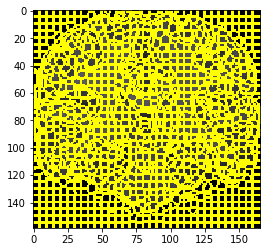

In [145]:
segments = slic(img_crop.astype('double'), n_segments=N_SEG, compactness=COMPACTNESS)
img_slice = img_crop[:, :, 50].squeeze()
label_slice = label_crop[:, :, 50].squeeze()
segments_slice = segments[:, :, 50].squeeze()
plt.imshow(mark_boundaries(img_slice, segments_slice))

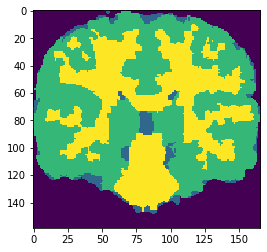

In [146]:
label_recon = label_reconstruct(label_slice, segments_slice)
plt.imshow(label_recon)

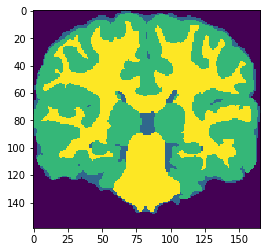

In [125]:
plt.imshow(label_crop[:, :, 50].squeeze())

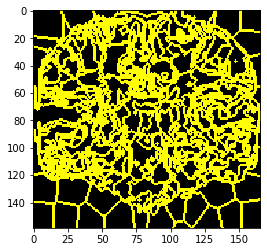

In [50]:
plt.imshow(mark_boundaries(label_slice, segments_slice))